In [33]:
"""
Comprehensive Examples for All Asset Classes
"""
import numpy as np
from datetime import datetime
from assetpricing.utils.date_handling import day_count
from assetpricing.fixed_income.bond_pricing import (
    zero_coupon_pv,
    fixed_coupon_bond_pv,
    calculate_ytm
)
from assetpricing.fixed_income.yield_curves import YieldCurveBootstrapper
from assetpricing.fixed_income.risk_measures import (
    macaulay_duration,
    modified_duration,
    convexity
)
from assetpricing.derivatives.options.black_scholes import black_scholes_price
from assetpricing.derivatives.options.binomial import BinomialTree
from assetpricing.derivatives.options.monte_carlo import MonteCarloPricer
from assetpricing.interest_rate.vasicek_short_rate_models import VasicekModel
from assetpricing.interest_rate.swaps import InterestRateSwap
from assetpricing.foreign_exchange.fx_forwards import fx_forward_rate
from assetpricing.derivatives.volatility_models import (
    implied_volatility,
    plot_volatility_smile,
    plot_volatility_surface,
    plot_volatility_term_structure
)
from assetpricing.derivatives.futures import CostOfCarry
from assetpricing.credit.credit_risk import CreditDefaultSwap
from assetpricing.derivatives.volatility_models import implied_volatility
from assetpricing.foreign_exchange.fx_options import (
    garman_kohlhagen,
    fx_delta,
    fx_gamma,
    fx_vega,
    fx_theta,
    fx_rho,
    plot_sensitivity,
    plot_volatility_surface
)

# Fixed Income

### Zero coupon bond example

In [34]:
zc_price = zero_coupon_pv(
    face_value=100,          # Par value at maturity ($)
    time_to_maturity=2,      # Years until maturity
    ytm=0.05,                # Annual yield-to-maturity (5%)
    compounding_freq=0       # Compounding: 0=continuous, 1=annual, 2=semi-annual
)
print(f"Zero Coupon Bond PV: ${zc_price:.2f}")

Zero Coupon Bond PV: $90.48


### Fixed coupon bond example

In [35]:
times = [0.5, 1.0, 1.5, 2.0]  # Semi-annual payment times
bond_price = fixed_coupon_bond_pv(
    coupon_rate=0.05,        # Annual coupon rate (5%)
    face_value=100,          # Par value
    times=times,             # Cash flow timings (years)
    ytm=0.05,                # Yield to maturity
    compounding_freq=2       # 2:Semi-annual compounding
)
print(f"Fixed Coupon Bond PV: ${bond_price:.2f}")

Fixed Coupon Bond PV: $100.00


### YTM calculation

In [36]:
ytm = calculate_ytm(
    price=95,                # Current market price
    face_value=100,          # Par value
    coupon_rate=0.05,        # Annual coupon rate
    times=times,             # Cash flow timings
    compounding_freq=2,      # Semi-annual compounding
    guess=0.05               # Initial guess for solver
)
print(f"Calculated YTM: {ytm:.2%}")

Calculated YTM: 7.75%


### Yield Curve Bootstrapping

In [37]:
instruments = [
    (0.25, 0.0175),  # 3M
    (0.5, 0.0190),   # 6M
    (1.0, 0.0215),   # 1Y
    (2.0, 0.0230),   # 2Y
    (3.0, 0.0245),   # 3Y
    (5.0, 0.0260)    # 5Y
]

# %%
# 2. Bootstrap zero rates
yc = YieldCurveBootstrapper(instruments)
zero_rates = yc.bootstrap()

print("Bootstrapped Zero Rates:")
for t, r in sorted(zero_rates.items()):
    print(f"{t:>4} year: {r:.4f} ({r:.2%})")

Bootstrapped Zero Rates:
0.25 year: 0.0694 (6.94%)
 0.5 year: 0.0753 (7.53%)
 1.0 year: 0.0642 (6.42%)
 2.0 year: 0.0461 (4.61%)
 3.0 year: 0.0411 (4.11%)
 5.0 year: 0.0318 (3.18%)


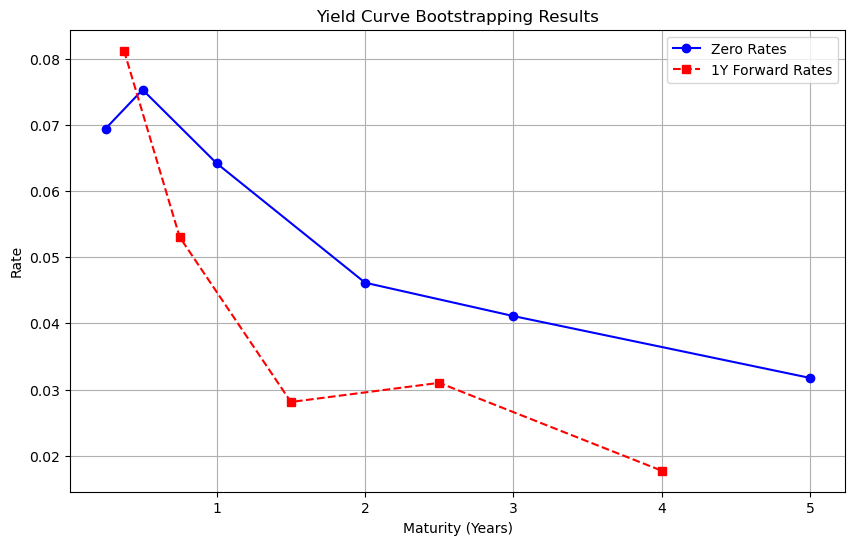

In [38]:
yc.plot_curve()

In [39]:
# Calculate 2Y1Y forward rate
forward_2y1y = yc.forward_rate(2.0, 3.0)
print(f"2Y1Y Forward Rate: {forward_2y1y:.4f} ({forward_2y1y:.2%})")

# Calculate 1Y2Y forward rate
forward_1y2y = yc.forward_rate(1.0, 3.0)
print(f"1Y2Y Forward Rate: {forward_1y2y:.4f} ({forward_1y2y:.2%})")

2Y1Y Forward Rate: 0.0310 (3.10%)
1Y2Y Forward Rate: 0.0296 (2.96%)


### Duration & Convexity

In [40]:
from assetpricing.fixed_income.risk_measures import macaulay_duration, modified_duration, convexity

cash_flows = [2.5, 2.5, 2.5, 102.5]  # Semi-annual payments
mac_dur = macaulay_duration(
    cash_flows=cash_flows,
    times=times,
    ytm=0.05,
    compounding_freq=2
)
mod_dur = modified_duration(mac_dur, 0.05, 2)
conv = convexity(cash_flows, times, 0.05, 2)

print(f"Macaulay Duration: {mac_dur:.2f} yrs")
print(f"Modified Duration: {mod_dur:.2f}")
print(f"Convexity: {conv:.2f}")


Macaulay Duration: 1.93 yrs
Modified Duration: 1.88
Convexity: 4.53


# Futures

### Basic Future Pricing

In [41]:
# Input parameters
spot = 100.0            # Current spot price ($)
r = 0.05                # Annual risk-free rate (5%)
T = 0.25                # Time to maturity (3 months)

In [42]:
basic_future = CostOfCarry.fair_value(
    spot_price=spot,
    risk_free_rate=r,
    time_to_maturity=T
)
print(f"Basic Futures Price: ${basic_future:.2f}")

Basic Futures Price: $101.26


### Commodity Futures with Storage Costs

In [43]:
storage_cost = 0.02     # 2% of spot price annually
convenience_yield = 0.01 # 1% annual benefit

commodity_future = CostOfCarry.fair_value(
    spot_price=1500,     # Gold spot price
    risk_free_rate=0.04,
    time_to_maturity=0.5,  # 6 months
    storage_cost=storage_cost,
    convenience_yield=convenience_yield
)
print(f"Gold Futures (6M) with Storage: ${commodity_future:.2f}")

Gold Futures (6M) with Storage: $1537.97


### Equity Index Futures with Dividends

In [44]:
div_yield = 0.03        # 3% annual dividend yield

equity_future = CostOfCarry.fair_value(
    spot_price=5000,     # S&P 500 index level
    risk_free_rate=0.05,
    time_to_maturity=0.25,  # 3 months
    dividend_yield=div_yield
)
print(f"Equity Index Futures: ${equity_future:.2f}")

Equity Index Futures: $5025.06


### Calculating Implied Convenience Yield

In [45]:
implied_cy = CostOfCarry.implied_convenience_yield(
    futures_price=1550,
    spot_price=1500,
    risk_free_rate=0.04,
    time_to_maturity=0.5,
    storage_cost=0.02  # Now properly included
)
print(f"Implied Convenience Yield: {implied_cy:.2%}")

Implied Convenience Yield: -0.56%


# Options

### Black-Scholes Option Pricing

In [46]:
bs_price = black_scholes_price(
    S=100,       # Spot price
    K=105,       # Strike price
    T=1,         # Time to expiration (years)
    r=0.05,      # Risk-free rate
    sigma=0.2,   # Volatility
    option_type='call'
)
print(f"BS Call Price: ${bs_price:.2f}")

BS Call Price: $8.02


### Binomial Tree (American Option)

In [47]:
binomial_price = BinomialTree(
    S=100,        # Spot price
    K=100,        # Strike price
    T=1,          # Time to expiration
    r=0.05,       # Risk-free rate
    sigma=0.2,    # Volatility
    steps=100,    # Number of tree steps
    option_type='put',
    american=True  # American exercise
).price()
print(f"Binomial American Put Price: ${binomial_price:.2f}")

Binomial American Put Price: $6.08


### Monte Carlo

In [48]:
mc_price = MonteCarloPricer(
    S=100,            # Spot price
    K=102,            # Strike price
    T=1,              # Time to expiration
    r=0.05,           # Risk-free rate
    sigma=0.2,        # Volatility
    n_simulations=100000,  # Number of paths
    n_steps=100       # Path resolution
).asian_option()
print(f"Asian Call Price: ${mc_price:.2f}")

Asian Call Price: $4.73


### Stochastic Volatility Pricing Example


In [49]:
# Basic parameters
params = {
    'S': 150.0,     # Spot price
    'K': 155.0,     # Strike price
    'T': 0.25,      # 3 months
    'r': 0.04,      # Risk-free rate
    'price': 7.20,  # Market price
    'option_type': 'call'
}

iv = implied_volatility(**params)
print(f"Basic Implied Volatility: {iv:.2%}")


Basic Implied Volatility: 29.17%


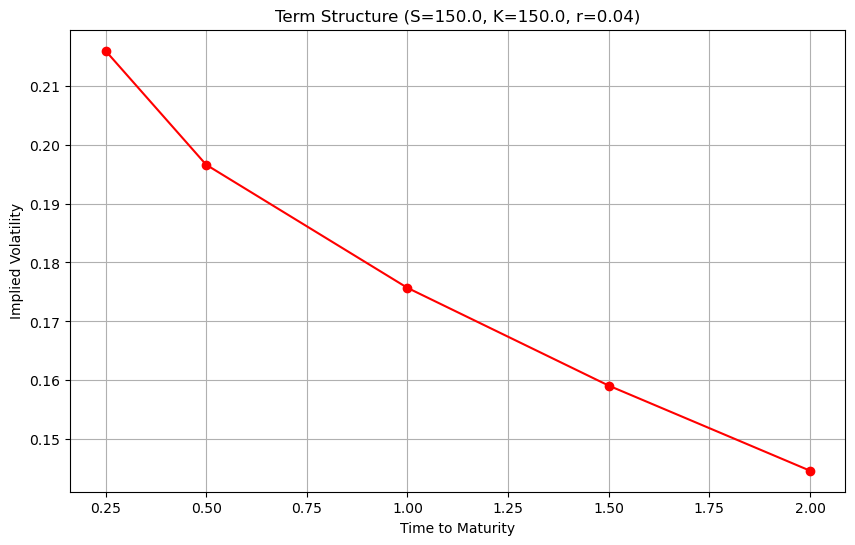

In [50]:
#Term Structure Analysis
# Fixed strike across multiple maturities

# %%
# Term structure parameters
maturities_ts = np.array([0.25, 0.5, 1.0, 1.5, 2.0])
prices_ts = np.array([7.2, 9.8, 13.5, 16.2, 18.4])  # ATM prices

plot_volatility_term_structure(
    S=150.0,
    r=0.04,
    K=150.0,  # ATM strike
    maturities=maturities_ts,
    prices=prices_ts,
    option_type='call'
)

# Interest Rate Models

### Vasicek Model Simulation

In [51]:
vasicek_rates = VasicekModel(
    a=0.1,     # Mean reversion speed
    b=0.05,    # Long-term mean rate
    sigma=0.02,# Volatility
    r0=0.03    # Initial rate
).simulate(T=1, steps=100, n_paths=5)
print("Vasicek Rate Paths:\n", vasicek_rates[:, 0])

Vasicek Rate Paths:
 [ 3.00000000e-02  2.67286319e-02  2.59896713e-02  1.85520204e-02
  1.94761103e-02  2.09361834e-02  2.28458476e-02  1.89045042e-02
  1.75455527e-02  1.48072626e-02  1.51169549e-02  1.90335137e-02
  1.69052504e-02  1.67698742e-02  1.68356481e-02  1.71150597e-02
  1.82312338e-02  1.75940894e-02  1.97339676e-02  1.90541376e-02
  1.85087140e-02  2.22696086e-02  2.28635917e-02  2.32122537e-02
  2.25386241e-02  2.17650488e-02  1.97662899e-02  2.09354238e-02
  2.02567609e-02  1.86623070e-02  1.71209117e-02  1.52225271e-02
  1.64296110e-02  2.05292488e-02  2.42429237e-02  2.94104690e-02
  2.87331849e-02  3.28554609e-02  3.32095597e-02  3.29224707e-02
  3.26937105e-02  3.29000524e-02  3.20628461e-02  3.30373172e-02
  3.12491869e-02  3.44605134e-02  3.14607442e-02  2.84962677e-02
  2.96973991e-02  3.18178483e-02  3.07822574e-02  2.84370866e-02
  2.91400612e-02  2.85837117e-02  2.85225567e-02  2.81813373e-02
  2.31796318e-02  2.27812015e-02  2.23207246e-02  1.91649014e-02
  2.

### Vasicek Simulation and plotting

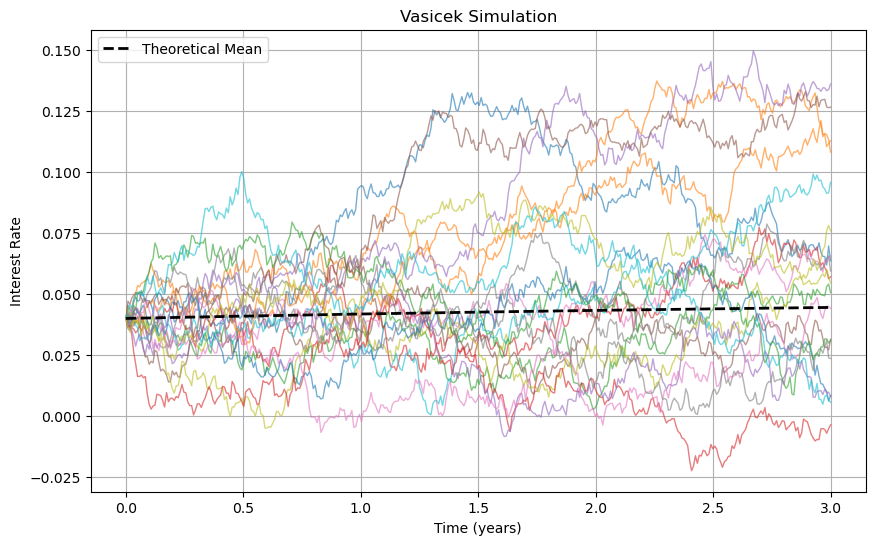

In [52]:
# Simulation and plotting
model = VasicekModel(a=0.2, b=0.05, sigma=0.03, r0=0.04)
rates = model.simulate(T=3, steps=365, n_paths=20)  # Daily simulation for 3 years
model.plot_simulation(rates, T=3, title="Vasicek Simulation")

### Swap Pricing

In [53]:
swap = InterestRateSwap(
    notional=1_000_000,  # Principal amount
    fixed_rate=0.03,     # Fixed leg rate
    tenor=5,             # Swap duration (years)
    day_count='30/360'   # Day count convention
)
# Simplified discount factors
swap_rate = swap.swap_rate(
    discount_factors={5: 0.85},  # {year: discount_factor}
    floating_leg_pv=1_000_000 * 0.025 * 5 * 0.85
)
print(f"Fair Swap Rate: {swap_rate:.2%}")

Fair Swap Rate: 2.50%


# FX 

### FX Option Pricing

In [54]:
from assetpricing.foreign_exchange.fx_options import garman_kohlhagen
# ### 1. Basic Option Pricing
# Parameters:
S = 1.1500   # Spot EUR/USD
K = 1.1600    # Strike price
T = 0.5       # 6 months to expiration
rd = 0.025    # USD rate (domestic)
rf = 0.015    # EUR rate (foreign)
sigma = 0.095 # Implied volatility

# Calculate prices
call_price = garman_kohlhagen(S, K, T, rd, rf, sigma, 'call')
put_price = garman_kohlhagen(S, K, T, rd, rf, sigma, 'put')

print(f"EUR Call/USD Put Price: {call_price:.4f} USD per EUR")
print(f"EUR Put/USD Call Price: {put_price:.4f} USD per EUR")


EUR Call/USD Put Price: 0.0286 USD per EUR
EUR Put/USD Call Price: 0.0328 USD per EUR


In [55]:
# ### 2. Greeks Calculation
from scipy.stats import norm
def fx_option_delta(S, K, T, rd, rf, sigma, option_type='call'):
    d1 = (np.log(S/K) + (rd - rf + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    if option_type == 'call':
        return np.exp(-rf*T) * norm.cdf(d1)
    else:
        return np.exp(-rf*T) * (norm.cdf(d1) - 1)

call_delta = fx_option_delta(S, K, T, rd, rf, sigma, 'call')
put_delta = fx_option_delta(S, K, T, rd, rf, sigma, 'put')

print(f"\nCall Delta: {call_delta:.4f}")
print(f"Put Delta: {put_delta:.4f}")


Call Delta: 0.4880
Put Delta: -0.5045


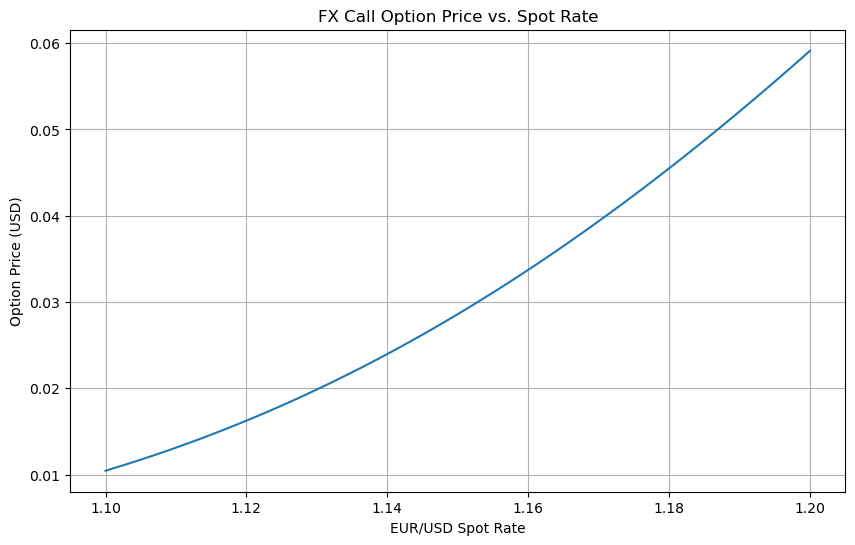

In [56]:
# ### 3. Sensitivity Analysis
# Price vs. Spot Rate

import matplotlib.pyplot as plt

spots = np.linspace(1.10, 1.20, 50)
prices = [garman_kohlhagen(s, K, T, rd, rf, sigma, 'call') for s in spots]

plt.figure(figsize=(10,6))
plt.plot(spots, prices)
plt.title("FX Call Option Price vs. Spot Rate")
plt.xlabel("EUR/USD Spot Rate")
plt.ylabel("Option Price (USD)")
plt.grid(True)
plt.show()

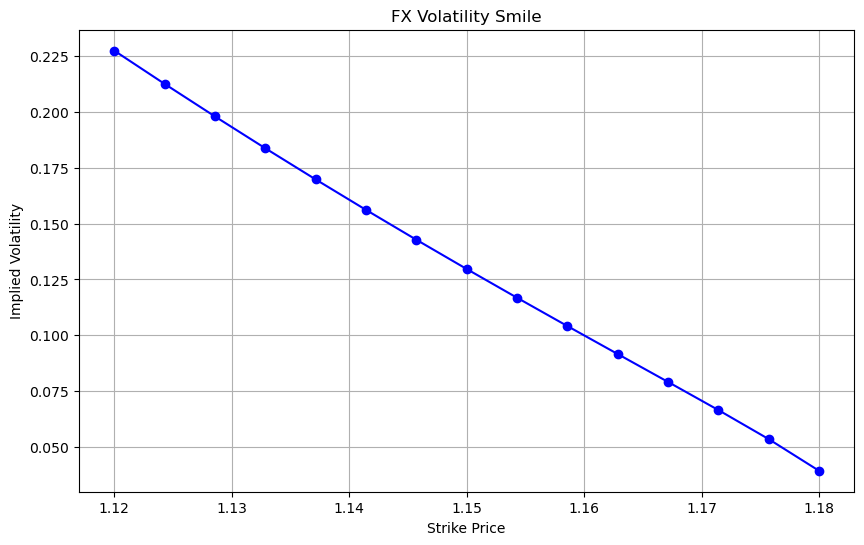

In [57]:
# ### 4. Volatility Smile Analysis
strikes = np.linspace(1.12, 1.18, 15)
implied_vols = []

for strike in strikes:
    # Assume market price follows Garman-Kohlhagen with 10% volatility
    price = garman_kohlhagen(S, strike, T, rd, rf, 0.10, 'call')
    # Calculate implied volatility
    iv = implied_volatility(price, S, strike, T, rd, rf)
    implied_vols.append(iv)

plt.figure(figsize=(10,6))
plt.plot(strikes, implied_vols, 'bo-')
plt.title("FX Volatility Smile")
plt.xlabel("Strike Price")
plt.ylabel("Implied Volatility")
plt.grid(True)
plt.show()

In [58]:
# FX Options Analysis Notebook
# **Scenario:** Analyze EUR/USD options for a US investor


# Basic Option Pricing
# Using `garman_kohlhagen` for valuation

# Market parameters
params = {
    'S': 1.1500,    # Spot EUR/USD
    'T': 0.5,       # 6 months
    'rd': 0.025,    # USD rate (domestic)
    'rf': 0.015,    # EUR rate (foreign)
    'sigma': 0.095  # Volatility
}


In [59]:
# Calculate ATM option prices
atm_call = garman_kohlhagen(**params, K=1.1500, option_type='call')
atm_put = garman_kohlhagen(**params, K=1.1500, option_type='put')

print(f"ATM Call Price: {atm_call:.4f}")
print(f"ATM Put Price: {atm_put:.4f}")

# Greeks Calculation
# Using risk sensitivity functions
# Calculate Greeks for ATM call
greeks = {
    'Delta': fx_delta(**params, K=1.1500, option_type='call'),
    'Gamma': fx_gamma(**params, K=1.1500),
    'Vega': fx_vega(**params, K=1.1500),
    'Theta': fx_theta(**params, K=1.1500, option_type='call'),
    'Rho': fx_rho(**params, K=1.1500, option_type='call'),
    'Phi': fx_phi(**params, K=1.1500, option_type='call')
}

print("\nATM Call Greeks:")
for greek, value in greeks.items():
    print(f"{greek + ':':<6} {value:.6f}")




ATM Call Price: 0.0334
ATM Put Price: 0.0277

ATM Call Greeks:
Delta: 0.538953
Gamma: 5.095803
Vega:  0.320112
Theta: -0.025049
Rho:   0.293179
Phi:   -0.309898


In [ ]:
# Sensitivity Analysis
# Using `price_sensitivity` function

# Spot rate sensitivity

# Now call with parameter='spot'
call_prices = price_sensitivity(param_range=spots, parameter='spot', K=1.1600, **params)

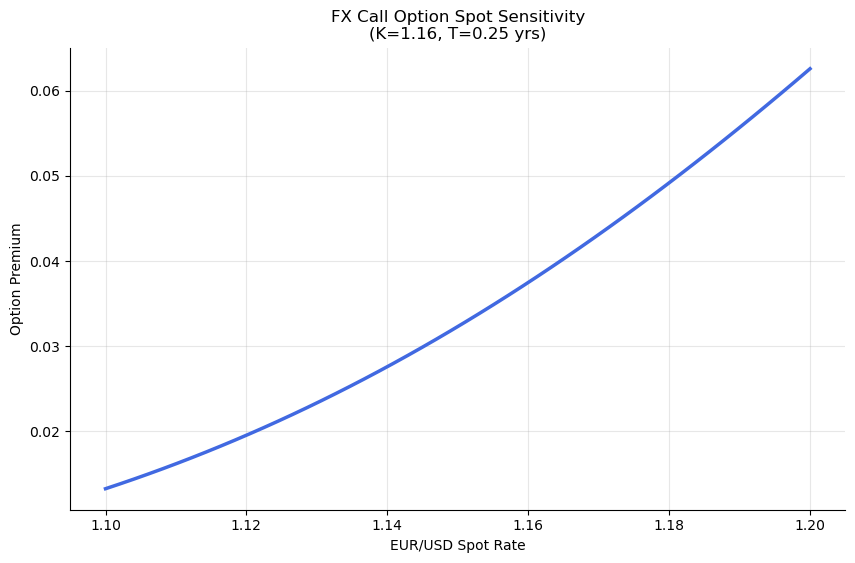

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'FX Call Option Spot Sensitivity\n(K=1.16, T=0.25 yrs)'}, xlabel='EUR/USD Spot Rate', ylabel='Option Premium'>)

In [62]:
# Sensitivity plot for spot rates
spots = np.linspace(1.10, 1.20, 50)
plot_sensitivity(spots, 'spot', K=1.16, T=0.25, rd=0.03, rf=0.01, sigma=0.15, S=1.15)

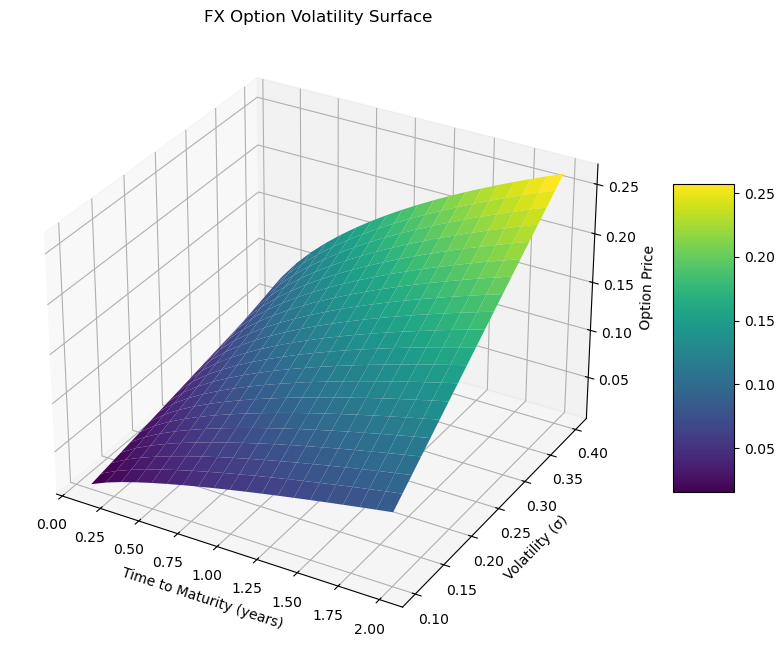

In [63]:
# Volatility surface plot
T_values = np.linspace(0.1, 2.0, 20)
sigma_range = np.linspace(0.1, 0.4, 20)
plot_volatility_surface(S=1.15, K=1.16, T_values=T_values, rd=0.03, rf=0.01, sigma_range=sigma_range)

### FX Forward Pricing

In [64]:
forward_rate = fx_forward_rate(
    spot_rate=1.25,      # Current FX rate (USD/EUR)
    domestic_rate=0.05,  # USD interest rate
    foreign_rate=0.03,   # EUR interest rate
    T=0.5,               # Time to delivery (years)
    continuous=True      # Continuous compounding
)
print(f"6M Forward Rate: {forward_rate:.4f} USD/EUR")

6M Forward Rate: 1.2626 USD/EUR


# Credit Risk

In [22]:
term_structure = {
    1: 0.952,  # Year 1 discount factor
    2: 0.907,  # Year 2 discount factor
    3: 0.864,
    4: 0.823,
    5: 0.785
}

cds = CreditDefaultSwap(
    notional=10_000_000,
    spread=0.02,
    recovery_rate=0.40,
    term_structure=term_structure  # Use dictionary directly
)

# Now calculations will work
hr = 0.03
print(f"Premium Leg PV: ${cds.pv_premium_leg(hr):,.2f}")
print(f"Default Leg PV: ${cds.pv_default_leg(hr):,.2f}")
print(f"Fair Spread: {cds.fair_spread(hr):.4f}")

Premium Leg PV: $794,654.48
Default Leg PV: $726,024.96
Fair Spread: 6.7682
